In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math

# =============================================================================
# LDPE Deterministic Simulation (4-lump model)
# =============================================================================
def simulate_LDPE(residence_time, temprature):
    A_base = np.array([7.52e6, 5.07e8, 9.17e1, 2.30e9, 5.42e6, 6.17e7])
    Ea_base = np.array([147e3, 189e3, 313e3, 166e3, 213e3, 150e3])
    R = 8.314
    k = A_base * np.sqrt(temprature) * np.exp(-Ea_base / (R * temprature))
    k1, k2, k3, k4, k5, k6 = k

    def model_LDPE(t, w):
        R_mass, SO, LL, G = w
        dRdt  = - (k1 + k2 + k3) * R_mass
        dSOdt = k1 * R_mass - (k4 + k5) * SO
        dLLdt = k2 * R_mass + k4 * SO - k6 * LL
        dGdt  = k3 * R_mass + k5 * SO + k6 * LL
        return [dRdt, dSOdt, dLLdt, dGdt]

    t_eval = np.linspace(0, residence_time, 100)
    sol = solve_ivp(model_LDPE, [0, residence_time], [1, 0, 0, 0],
                    t_eval=t_eval, atol=1e-8, rtol=1e-6)
    final = sol.y[:, -1]
    residue, spindle_oil, light_liquids, gas = final
    liquid = spindle_oil + light_liquids
    return {"plastic": residue, "gas": gas, "liquid": liquid, "char": 0.0}

# =============================================================================
# HDPE Deterministic Simulation (4-lump thin bed with char formation)
# =============================================================================
def simulate_HDPE(residence_time, temprature):
    R = 8.314

    params_thin_bed = {
        'k1': {'A': 1.52e10 / 60, 'Ea': 174.40e3},
        'k2': {'A': 6.00e11 / 60, 'Ea': 194.84e3},
        'k3': {'A': 6.31e12 / 60, 'Ea': 203.92e3},
        'k4': {'A': 8.54 / 60,    'Ea': 57.45e3}
    }

    def arrhenius(A, Ea, T):
        return A * np.exp(-Ea / (R * T))

    k1_HDPE = arrhenius(params_thin_bed['k1']['A'], params_thin_bed['k1']['Ea'], temprature)
    k2_HDPE = arrhenius(params_thin_bed['k2']['A'], params_thin_bed['k2']['Ea'], temprature)
    k3_HDPE = arrhenius(params_thin_bed['k3']['A'], params_thin_bed['k3']['Ea'], temprature)
    k4_HDPE = arrhenius(params_thin_bed['k4']['A'], params_thin_bed['k4']['Ea'], temprature)

    def model_HDPE(t, y):
        hdpe, gas, oil, wax = y
        dhdpe = - (k1_HDPE + k2_HDPE + k3_HDPE) * hdpe
        dgas  = k1_HDPE * hdpe
        doil  = k3_HDPE * hdpe + k4_HDPE * wax
        dwax  = k2_HDPE * hdpe - k4_HDPE * wax
        return [dhdpe, dgas, doil, dwax]

    t_eval_HDPE = np.linspace(0, residence_time, 100)
    sol_HDPE = solve_ivp(model_HDPE, [0, residence_time], [1, 0, 0, 0],
                         t_eval=t_eval_HDPE, atol=1e-8, rtol=1e-6)
    final_HDPE = sol_HDPE.y[:, -1]
    hdpe_plastic, hdpe_gas, hdpe_oil, hdpe_wax = final_HDPE
    hdpe_liquid = hdpe_oil + hdpe_wax
    return {"plastic": hdpe_plastic, "gas": hdpe_gas, "liquid": hdpe_liquid, "char": 0.0}

# =============================================================================
# PP Deterministic Simulation (6-lump model)
# =============================================================================
def simulate_PP(residence_time, temprature):
    R = 8.314

    params_PP = {
        'k_melt': {'A': 3.20e15, 'Ea': 255e3},
        'k1p':    {'A': 2.00e2,  'Ea': 82e3},
        'k2p':    {'A': 1.00e5,  'Ea': 107e3},
        'k3p':    {'A': 5.00e14, 'Ea': 260e3},
        'k4p':    {'A': 2.90e8,  'Ea': 162e3},
        'k5p':    {'A': 5.42e6,  'Ea': 213e3},
        'k6p':    {'A': 6.17e7,  'Ea': 152e3},
        'k1c':    {'A': 1.07e13, 'Ea': 232.67e3},
        'k2c':    {'A': 1.37e-3, 'Ea': 215.74e3},
        'k3c':    {'A': 6.95,    'Ea': 393.89e3},
    }

    def calc_k(A, Ea, T):
        return A * np.exp(-Ea / (R * T))

    ks = {key: calc_k(params_PP[key]['A'], params_PP[key]['Ea'], temprature)
          for key in params_PP}

    def model_PP(t, y):
        P, W, S, L, G, C = y
        dPdt = -ks['k_melt'] * P
        dWdt = ks['k_melt'] * P - (ks['k1p'] + ks['k2p'] + ks['k3p'] + ks['k1c']) * W
        dSdt = ks['k1p'] * W - (ks['k4p'] + ks['k5p'] + ks['k2c']) * S
        dLdt = ks['k2p'] * W + ks['k4p'] * S - (ks['k6p'] + ks['k3c']) * L
        dGdt = ks['k3p'] * W + ks['k5p'] * S + ks['k6p'] * L
        dCdt = ks['k1c'] * W + ks['k2c'] * S + ks['k3c'] * L
        return [dPdt, dWdt, dSdt, dLdt, dGdt, dCdt]

    t_eval_PP = np.linspace(0, residence_time, 100)
    sol_PP = solve_ivp(model_PP, [0, residence_time], [1, 0, 0, 0, 0, 0],
                       t_eval=t_eval_PP, atol=1e-8, rtol=1e-6)
    final_PP = sol_PP.y[:, -1]
    plastic, wax, sop, llp, gas, char = final_PP
    liquid_PP = wax + sop + llp
    return {"plastic": plastic, "gas": gas, "liquid": liquid_PP, "char": char}

# =============================================================================
# Combine Polymer Simulations with Given Flow Rates
# =============================================================================
def combine_polymer_simulations(flow_HDPE, flow_LDPE, flow_PP, temprature, residence_time, verbose=False):
    # Simulate each polymer with consistent residence time
    results_HDPE = simulate_HDPE(residence_time, temprature)
    results_LDPE = simulate_LDPE(residence_time, temprature)
    results_PP   = simulate_PP(residence_time, temprature)

    # Compute mass contributions
    mass_gas    = (flow_HDPE * results_HDPE["gas"] + flow_LDPE * results_LDPE["gas"] +
                   flow_PP * results_PP["gas"])
    mass_liquid = (flow_HDPE * results_HDPE["liquid"] + flow_LDPE * results_LDPE["liquid"] +
                   flow_PP * results_PP["liquid"])
    mass_char   = (flow_HDPE * results_HDPE["char"] + flow_LDPE * results_LDPE["char"] +
                   flow_PP * results_PP["char"])
    mass_plastic = (flow_HDPE * results_HDPE["plastic"] + flow_LDPE * results_LDPE["plastic"] +
                    flow_PP * results_PP["plastic"])
    total_flow = flow_HDPE + flow_LDPE + flow_PP

    overall_gas     = (mass_gas / total_flow) * 100
    overall_liquid  = (mass_liquid / total_flow) * 100
    overall_char    = (mass_char / total_flow) * 100
    overall_plastic = (mass_plastic / total_flow) * 100

    if verbose:
        print("Overall Composition (weighted by flow rates):")
        print(f"Gas:     {overall_gas:.1f}%")
        print(f"Liquid:  {overall_liquid:.1f}%")
        print(f"Char:    {overall_char:.1f}%")
        print(f"Plastic: {overall_plastic:.1f}%")
        print(f"Gas:     {mass_gas:.1f} tonnes/day")
        print(f"Liquid:  {mass_liquid:.1f} tonnes/day")
        print(f"Char:    {mass_char:.1f} tonnes/day")
        print(f"Plastic: {mass_plastic:.1f} tonnes/day")

        # Plot Overall Composition as a Pie Chart
        labels = ['Gas', 'Liquid', 'Char', 'Plastic']
        sizes = [overall_gas, overall_liquid, overall_char, overall_plastic]
        colors = ['gold', 'skyblue', 'lightcoral', 'silver']
        plt.figure(figsize=(6, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title("Overall Product Composition")
        plt.show()

    return mass_gas, mass_liquid, mass_char, mass_plastic, total_flow

# =============================================================================
# Fluidizing Gas Calculation
# =============================================================================
def fluidizing_gas(D_t, u0, residence_time, temprature, verbose=False):
    g = 980  # gravitational acceleration, cm/s²

    # Solid properties
    rho_sand = 2.6
    rho_plastic = 0.94
    rho_char = 1.6
    dp_sand = 0.05
    dp_plastic = 0.5
    dp_char = 0.0037

    # Shape factors
    psi_sand = 0.89
    psi_plastic = 0.7
    psi_char = 0.8

    # Gas properties
    rho_g = 0.000084      # g/cm³
    mu = 1.63e-4          # g/cm·s

    A_c = np.pi * (D_t/2)**2

    v0 = u0 * np.pi * D_t**2 / 4

    def calculate_n(rho):
        return g * (rho - rho_g)

    n_plastic = calculate_n(rho_plastic)
    n_sand    = calculate_n(rho_sand)
    n_char    = calculate_n(rho_char)

    def calculate_ep_mf(psi, n, rho, dp):
        return 0.586 * psi ** -0.72 * (mu**2 / (rho_g * n * dp**3))**0.029 * (rho_g / rho)**0.021

    ep_sand    = calculate_ep_mf(psi_sand, n_sand, rho_sand, dp_sand)
    ep_plastic = calculate_ep_mf(psi_plastic, n_plastic, rho_plastic, dp_plastic)
    ep_char    = calculate_ep_mf(psi_char, n_char, rho_char, dp_char)

    def calculate_umf(psi, dp, n, ep):
        return (psi * dp)**2 / (150 * mu) * n * ep**3 / (1 - ep)

    umf_sand    = calculate_umf(psi_sand, dp_sand, n_sand, ep_sand)
    umf_plastic = calculate_umf(psi_plastic, dp_plastic, n_plastic, ep_plastic)
    umf_char    = calculate_umf(psi_char, dp_char, n_char, ep_char)

    def calculate_ut(n, dp):
        return (1.78e-2 * n**2 / (rho_g * mu))**(1/3) * dp

    ut_sand    = calculate_ut(n_sand, dp_sand)
    ut_plastic = calculate_ut(n_plastic, dp_plastic)
    ut_char    = calculate_ut(n_char, dp_char)

    def calculate_Rep(u, dp):
        return (rho_g * dp * u) / mu

    Re_sand_ut = calculate_Rep(ut_sand, dp_sand)
    Re_plastic_ut = calculate_Rep(ut_plastic, dp_plastic)
    Re_char_ut = calculate_Rep(ut_char, dp_char)
    Re_sand_umf = calculate_Rep(umf_sand, dp_sand)
    Re_plastic_umf = calculate_Rep(umf_plastic, dp_plastic)
    Re_char_umf = calculate_Rep(umf_char, dp_char)

    height = residence_time * u0
    db0 = 0.00376 * (u0 - umf_sand)**2
    dbm = 0.652 * (A_c * (u0 - umf_sand))**0.4
    db = dbm - (dbm - db0) * np.exp(- (0.3 * (height/2)) / D_t)
    ubr = 0.71 * np.sqrt(g * db)
    ub = u0 - umf_sand + ubr
    delta = (u0 - umf_sand) / (ub - umf_sand * (1 + 0.2))
    W = (height/2) * (A_c * (1 - delta) * (1 - ep_sand) * rho_sand)
    volume = height * A_c
    gasflowrate = u0 * A_c
    gasflow = ((gasflowrate * rho_g) / 1000000) * 3600 * 24

    HE = gasflow * 11.574 * 2.989 * ((temprature - 273) - 17)

    if verbose:
        print(f"Height of Reactor: {height:.3g} cm")
        print(f"Weight of Sand: {W / 1000:.3g} kg")
        print(f"Volume of Reactor: {volume * 1e-6:.3g} m³")
        print(f"Fluidizing gas heating requirement: {HE:.3g} W")
    return gasflow, HE, height/2

# =============================================================================
# Plastic Power Calculator
# =============================================================================
def PlasticPowerCalculator(flow_HDPE, flow_LDPE, flow_PP, temprature, verbose=False):
    heatR_ldpe = 473  # J/g
    heatR_hdpe = 438
    heatR_PP = 542
    Tmldpe = 112  # °C
    tmhdpe = 136
    tmpp = 164
    Trldpe = temprature - 273
    Trhdpe = temprature - 273
    Trpp = temprature - 273
    Tpin = 10  # °C

    Aghdpe = 4.376
    Agldpe = 6.447
    Agpp = 5.992
    Bgldpe = 2106
    Bghdpe = 1674
    Bgpp = 1636
    Amldpe = 3.336
    Amhdpe = 3.250
    Ampp = 3.095
    Bmldpe = 2238
    Bmhdpe = 2191
    Bmpp = 2161
    hfldpe = 142
    hfhdpe = 235
    hfpp   = 116

    def Cp(A, B, T):
        return (A * T + B) / 1000

    Cpgldpe = Cp(Agldpe, Bgldpe, Tmldpe)
    Cpghdpe = Cp(Aghdpe, Bghdpe, tmhdpe)
    Cpgpp   = Cp(Agpp, Bgpp, tmpp)
    Cpmldpe = Cp(Amldpe, Bmldpe, Trldpe)
    Cpmhdpe = Cp(Amhdpe, Bmhdpe, Trhdpe)
    Cpmpp   = Cp(Ampp, Bmpp, Trpp)

    hldpe = Cpgldpe * (Tmldpe - Tpin) + hfldpe + Cpmldpe * (Trldpe - Tmldpe) + heatR_ldpe
    hhdpe = Cpghdpe * (tmhdpe - Tpin) + hfhdpe + Cpmhdpe * (Trhdpe - tmhdpe) + heatR_hdpe
    hpp   = Cpgpp * (tmpp - Tpin) + hfpp + Cpmpp * (Trpp - tmpp) + heatR_PP

    Mldpe = flow_HDPE * 11.574  # tonnes/day to g/s
    Mhdpe = flow_LDPE * 11.574
    Mpp   = flow_PP * 11.574
    powerplastic = Mldpe * hldpe + Mhdpe * hhdpe + Mpp * hpp

    if verbose:
        print(f'Plastic Heat Requirement: {powerplastic:.2g} W')
    return powerplastic

# =============================================================================
# Salt Calculator
# =============================================================================
def saltcalculator(power, temprature, height, D_t, verbose=False):
    Di = D_t / 100
    twall = 6.5e-3
    Do = Di + 2 * twall
    h = height / 100
    Tr = temprature
    jacket_thickness = 0.03
    Q_base = power
    k_wall = 126
    cp_salt = 1200
    m_salt = 200
    rho_salt = 1700
    k_insulation = 0.12
    T_environment = 60 + 273

    r_i = Di / 2
    r_o = Do / 2
    r_outer_jacket = r_o + jacket_thickness
    r_outer_insulation = r_outer_jacket + 0.15
    #print(r_outer_insulation)
    def outer_temperature(Q, k, L, T_i, r_i, r_o):
        return T_i + (Q * np.log(r_o / r_i)) / (2 * np.pi * k * L)

    def heat_loss_to_environment(k_insulation, L, T_outer_jacket, T_environment, r_outer_jacket, r_outer_insulation):
        thermal_resistance = np.log(r_outer_insulation / r_outer_jacket) / (2 * np.pi * k_insulation * L)
        return (T_outer_jacket - T_environment) / thermal_resistance

    def salt_outlet_temperature(m, Tsin, Q, cp):
        return Tsin - Q / (cp * m)

    tol = 1e-3
    max_iter = 100
    Q_env = 0.0

    for i in range(max_iter):
        Q_total = Q_base + Q_env
        T_o_wall = outer_temperature(Q_total, k_wall, h, Tr, r_i, r_o)
        T_outer_jacket = T_o_wall
        new_Q_env = heat_loss_to_environment(k_insulation, h, T_outer_jacket, T_environment,
                                               r_outer_jacket, r_outer_insulation)
        if np.abs(new_Q_env - Q_env) < tol:
            Q_env = new_Q_env
            break
        Q_env = new_Q_env

    Q_total = Q_base + Q_env
    T_o_wall = outer_temperature(Q_total, k_wall, h, Tr, r_i, r_o)
    T_salt_in = T_o_wall - 273
    Tsout_salt = salt_outlet_temperature(m_salt, T_salt_in, Q_total, cp_salt)
    V_dot_salt = m_salt / rho_salt

    r_inner_jacket = r_o
    r_outer_jacket_correct = r_inner_jacket + jacket_thickness
    jacket_area = np.pi * (r_outer_jacket_correct**2 - r_inner_jacket**2)
    salt_speed = V_dot_salt / jacket_area
    pipelength = 22
    circulationtime = pipelength / salt_speed
    TotalSalt = circulationtime * m_salt

    if verbose:
        print(f"Converged Reactor Wall Outer Temperature: {T_o_wall - 273:.3f} °C")
        print(f"Converged Environmental Heat Loss: {Q_env:.3g} W")
        print(f"Total Heat Transfer (Q_total): {Q_total:.3g} W")
        print(f"Salt Inlet Temperature: {T_salt_in:.3g} °C")
        print(f"Salt Outlet Temperature: {Tsout_salt:.3g} °C")
        print(f"Volumetric Flow Rate of Salt: {V_dot_salt:.3g} m³/s")
        print(f"Jacket Cross-Sectional Area: {jacket_area:.3g} m²")
        print(f"Salt Speed: {salt_speed:.3g} m/s")
        print(f"Circulation Time: {circulationtime:.3g} s")
        print(f"Total Salt: {TotalSalt/1000:.3g} tonnes")
    return TotalSalt, T_salt_in, Tsout_salt, Q_total

# =============================================================================
# Fired Heater Design
# =============================================================================
def fired_heater_design(radiant_duty_mw, convection_duty_mw, verbose=False):
    max_flux_w_m2 = 31000
    tube_od_m = 0.1683
    tube_length_m = 10
    tube_pitch_factor = 2
    combustion_efficiency = 0.90

    total_duty_w = (radiant_duty_mw + convection_duty_mw) * 1e6
    radiant_duty_w = radiant_duty_mw * 1e6
    convection_duty_w = convection_duty_mw * 1e6

    required_surface_area_m2 = radiant_duty_w / max_flux_w_m2
    pipe_length_m = required_surface_area_m2 / (math.pi * tube_od_m)
    num_tubes = round(pipe_length_m / tube_length_m)
    if num_tubes % 2 != 0:
        num_tubes += 1

    tube_pitch_m = tube_pitch_factor * tube_od_m
    circumference_m = tube_pitch_m * num_tubes
    tube_circle_diameter_m = circumference_m / math.pi

    min_burner_diameter_m = 4
    if tube_circle_diameter_m < min_burner_diameter_m:
        num_tubes = 42
        tube_length_m = required_surface_area_m2 / (math.pi * tube_od_m * num_tubes)
        tube_circle_diameter_m = (tube_pitch_m * num_tubes) / math.pi

    required_heat_input_w = total_duty_w / combustion_efficiency
    required_heat_input_mw = required_heat_input_w / 1e6
    convection_flux_w_m2 = 15000
    convection_surface_area_m2 = convection_duty_w / convection_flux_w_m2

    methane_heat_of_combustion = 55.5e6
    methane_mass_flow_rate = total_duty_w / methane_heat_of_combustion
    air_fuel_ratio = 17.19
    air_mass_flow_rate = methane_mass_flow_rate * air_fuel_ratio
    air_density = 1.225
    air_volume_flow_rate = air_mass_flow_rate / air_density
    co2_mass_flow_rate_kg_s = methane_mass_flow_rate * (44 / 16)
    co2_mass_flow_rate_kg_h = co2_mass_flow_rate_kg_s * 3600

    if verbose:
        print("Radiant Section Design for Vertical Cylindrical Fired Heater")
        print("------------------------------------------------------------")
        print(f"Total Methane Consumption: {methane_mass_flow_rate:.3f} kg/s")
        print(f"Total Air Consumption: {air_mass_flow_rate:.3f} kg/s")
        print(f"Air Volume Flow Rate: {air_volume_flow_rate:.3f} m³/s")
        print(f"CO₂ Emissions: {co2_mass_flow_rate_kg_h:.2f} kg/h")
        print(f"Total Absorbed Duty: {(radiant_duty_mw + convection_duty_mw):.2f} MW")
        print(f"Assumed Combustion Efficiency: {combustion_efficiency*100:.1f}%")
        print(f"Total Heat Input Required from Burners: {required_heat_input_mw:.2f} MW")
        print(f"Radiant Duty: {radiant_duty_mw:.2f} MW")
        print(f"Required Radiant Surface Area: {required_surface_area_m2:.2f} m²")
        print(f"Total Pipe Length: {pipe_length_m:.2f} m")
        print(f"Number of Tubes: {num_tubes}")
        print(f"Tube Length: {tube_length_m:.2f} m")
        print(f"Tube Pitch: {tube_pitch_m:.2f} m")
        print(f"Tube Circle Diameter: {tube_circle_diameter_m:.2f} m")
        print("\nConvection Section")
        print("------------------")
        print(f"Convection Duty: {convection_duty_mw:.2f} MW")
        print(f"Estimated Required Convection Surface Area: {convection_surface_area_m2:.2f} m²")
        print("(Note: This is a rough estimate and actual value depends on finning type, rows, and layout)")
    return

# =============================================================================
# Combined Function
# =============================================================================
def combinedfunction(flow_HDPE, flow_LDPE, flow_PP, temprature, residence_time, D_t, u0, verbose=False):
    mass_gas, mass_liquid, mass_char, mass_plastic, total_flow = combine_polymer_simulations(
        flow_HDPE, flow_LDPE, flow_PP, temprature, residence_time, verbose=verbose)
    gasflow, HE, height = fluidizing_gas(D_t, u0, residence_time, temprature, verbose=verbose)
    power = PlasticPowerCalculator(flow_HDPE, flow_LDPE, flow_PP, temprature, verbose=verbose)
    saltcalculator(power, temprature, height, D_t, verbose=verbose)
    fired_heater_design(power / 1e6, HE / 1e6, verbose=verbose)
    return mass_gas, mass_liquid, mass_char, mass_plastic, total_flow


Combined Function for Reactor combinedreactorfunction(flow_HDPE, flow_LDPE, flow_PP,temprature,residence_time,D_t,u0,saltflow) Flowrates in tonnes/day, , temprature in K, residence time in s, D_t in cm and u0 in cm/s

Overall Composition (weighted by flow rates):
Gas:     59.0%
Liquid:  28.6%
Char:    12.5%
Plastic: 0.0%
Gas:     29.6 tonnes/day
Liquid:  14.3 tonnes/day
Char:    6.3 tonnes/day
Plastic: 0.0 tonnes/day


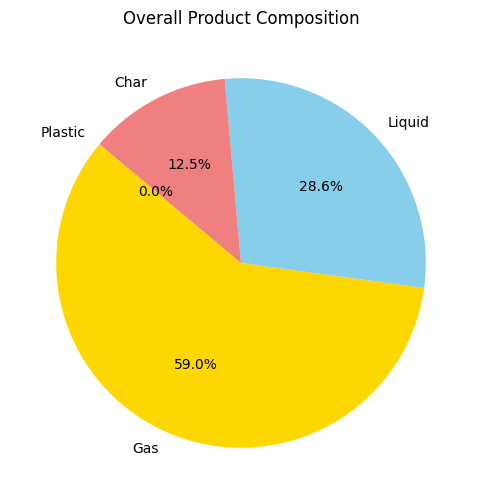

Height of Reactor: 400 cm
Weight of Sand: 195 kg
Volume of Reactor: 0.503 m³
Fluidizing gas heating requirement: 4.94e+04 W
Plastic Heat Requirement: 2.4e+06 W
Converged Reactor Wall Outer Temperature: 848.522 °C
Converged Environmental Heat Loss: 2.42e+03 W
Total Heat Transfer (Q_total): 2.4e+06 W
Salt Inlet Temperature: 849 °C
Salt Outlet Temperature: 839 °C
Volumetric Flow Rate of Salt: 0.118 m³/s
Jacket Cross-Sectional Area: 0.0418 m²
Salt Speed: 2.82 m/s
Circulation Time: 7.81 s
Total Salt: 1.56 tonnes
Radiant Section Design for Vertical Cylindrical Fired Heater
------------------------------------------------------------
Total Methane Consumption: 0.044 kg/s
Total Air Consumption: 0.759 kg/s
Air Volume Flow Rate: 0.619 m³/s
CO₂ Emissions: 436.87 kg/h
Total Absorbed Duty: 2.45 MW
Assumed Combustion Efficiency: 90.0%
Total Heat Input Required from Burners: 2.72 MW
Radiant Duty: 2.40 MW
Required Radiant Surface Area: 77.41 m²
Total Pipe Length: 146.41 m
Number of Tubes: 42
Tube Leng

In [ ]:
x=combinedfunction(15.09,15.09,20.02,273+800,2,40,200,verbose=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Steady-state values
flow_HDPE_ss = 15.09
flow_LDPE_ss = 15.09
flow_PP_ss   = 20.02
temperature_ss = 273 + 800  # equals 1073 K
residence_time = 2
D_t = 40
u0 = 200

# Number of Monte Carlo iterations
N = 5000

# Define the ±10% variation ranges for the flowrates and temperature
flow_HDPE_range = (flow_HDPE_ss * 0.9, flow_HDPE_ss * 1.1)
flow_LDPE_range = (flow_LDPE_ss * 0.9, flow_LDPE_ss * 1.1)
flow_PP_range   = (flow_PP_ss * 0.9, flow_PP_ss * 1.1)
temperature_range = (temperature_ss * 0.9, temperature_ss * 1.1)

# Array to store simulation results
# Each result is a tuple: (mass_gas, mass_liquid, mass_char, mass_plastic, total_flow)
results = []

# Monte Carlo simulation loop
for i in range(N):
    # Sample parameters uniformly within ±10% of their steady state values
    flow_HDPE_sample = np.random.uniform(*flow_HDPE_range)
    flow_LDPE_sample = np.random.uniform(*flow_LDPE_range)
    flow_PP_sample   = np.random.uniform(*flow_PP_range)
    temperature_sample = np.random.uniform(*temperature_range)

    # Evaluate the combined function using the sampled values
    # Note: combinedfunction should be defined in your environment.
    results.append(combinedfunction(flow_HDPE_sample, flow_LDPE_sample, flow_PP_sample,
                                    temperature_sample, residence_time, D_t, u0, verbose=False))


Mass Gas (tonnes/day) Statistics:
  Mean: 29.6
  Std:  1.35
  Min:  25.7
  Max:  33.3
  Median: 29.5
  5th, 25th, 75th, 95th percentiles: [27.35561788 28.58835768 30.50591613 31.7913976 ]

Mass Liquid (tonnes/day) Statistics:
  Mean: 14.3
  Std:  0.843
  Min:  12.1
  Max:  16
  Median: 14.3
  5th, 25th, 75th, 95th percentiles: [13.02069286 13.58673422 15.01324609 15.61890081]

Mass Char (tonnes/day) Statistics:
  Mean: 6.31
  Std:  0.813
  Min:  4.67
  Max:  8.36
  Median: 6.26
  5th, 25th, 75th, 95th percentiles: [5.06222088 5.67104306 6.89967696 7.738006  ]

Mass Plastic (tonnes/day) Statistics:
  Mean: 0.0524
  Std:  0.163
  Min:  3.2e-08
  Max:  1.09
  Median: 2.18e-07
  5th, 25th, 75th, 95th percentiles: [6.53652153e-08 1.17022493e-07 4.62373533e-04 4.24114628e-01]



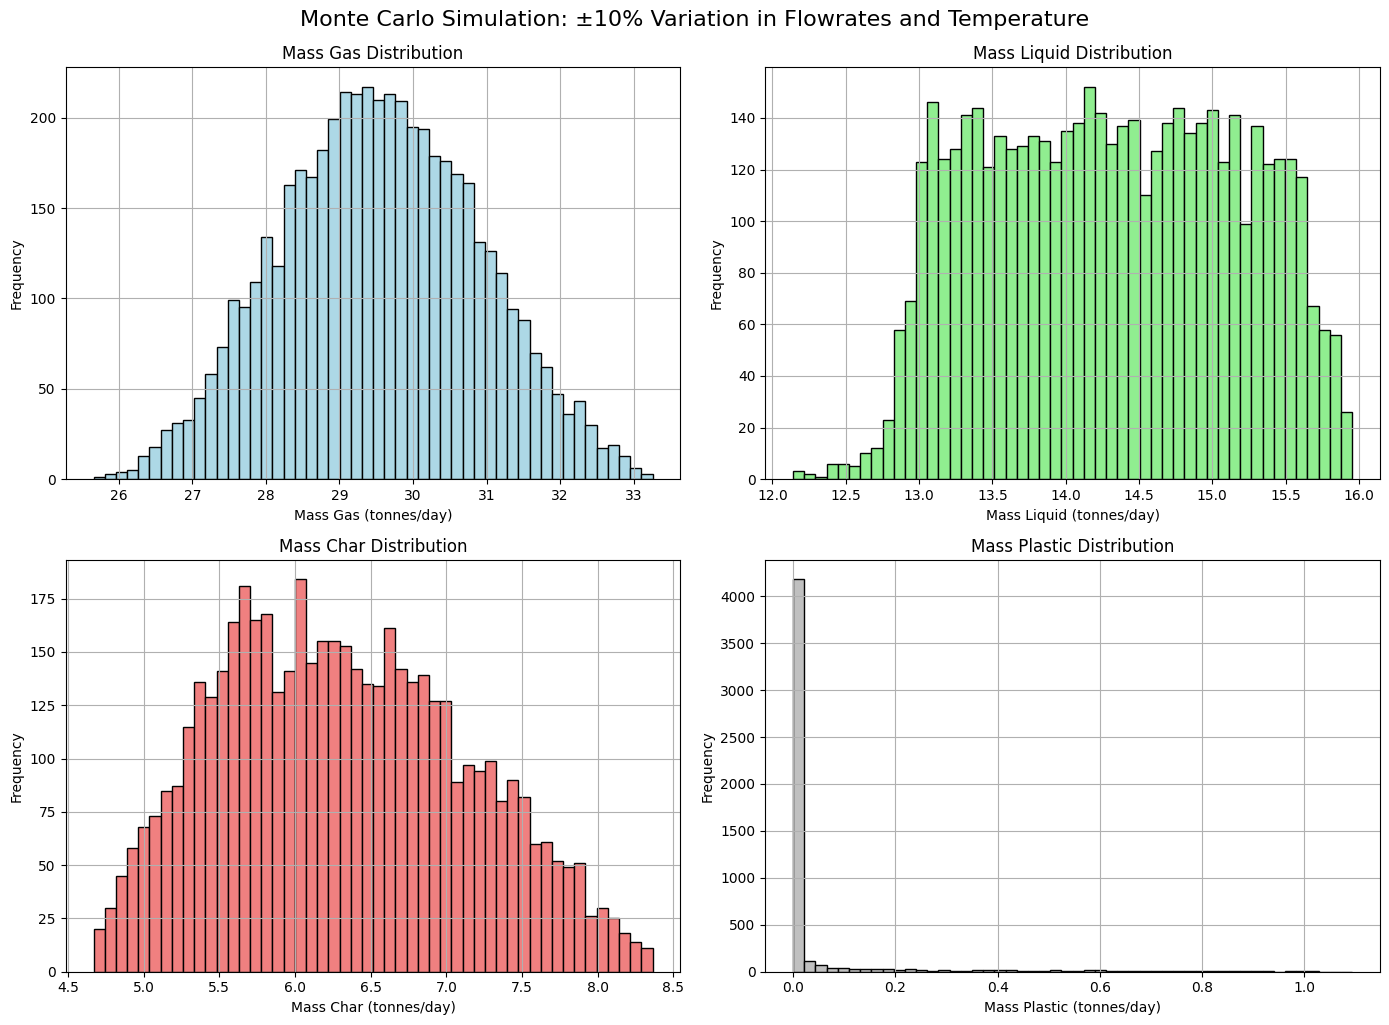

In [ ]:

# Convert the list of tuples to a NumPy array for further analysis
results = np.array(results)  # shape (N, 5)

# Unpack the results into separate arrays
mass_gas_results     = results[:, 0]
mass_liquid_results  = results[:, 1]
mass_char_results    = results[:, 2]
mass_plastic_results = results[:, 3]
total_flow_results   = results[:, 4]

# Function to compute and print statistics
def print_stats(data, label):
    mean_val = np.mean(data)
    std_val = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    median_val = np.median(data)
    percentiles = np.percentile(data, [5, 25, 75, 95])
    print(f"{label} Statistics:")
    print(f"  Mean: {mean_val:.3g}")
    print(f"  Std:  {std_val:.3g}")
    print(f"  Min:  {min_val:.3g}")
    print(f"  Max:  {max_val:.3g}")
    print(f"  Median: {median_val:.3g}")
    print(f"  5th, 25th, 75th, 95th percentiles: {percentiles}\n")

# Print computed statistics for each product stream
print_stats(mass_gas_results, "Mass Gas (tonnes/day)")
print_stats(mass_liquid_results, "Mass Liquid (tonnes/day)")
print_stats(mass_char_results, "Mass Char (tonnes/day)")
print_stats(mass_plastic_results, "Mass Plastic (tonnes/day)")

# Plot histograms for each product stream in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
bins = 50

axs[0, 0].hist(mass_gas_results, bins=bins, color='lightblue', edgecolor='black')
axs[0, 0].set_title("Mass Gas Distribution")
axs[0, 0].set_xlabel("Mass Gas (tonnes/day)")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].grid(True)

axs[0, 1].hist(mass_liquid_results, bins=bins, color='lightgreen', edgecolor='black')
axs[0, 1].set_title("Mass Liquid Distribution")
axs[0, 1].set_xlabel("Mass Liquid (tonnes/day)")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].grid(True)

axs[1, 0].hist(mass_char_results, bins=bins, color='lightcoral', edgecolor='black')
axs[1, 0].set_title("Mass Char Distribution")
axs[1, 0].set_xlabel("Mass Char (tonnes/day)")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True)

axs[1, 1].hist(mass_plastic_results, bins=bins, color='silver', edgecolor='black')
axs[1, 1].set_title("Mass Plastic Distribution")
axs[1, 1].set_xlabel("Mass Plastic (tonnes/day)")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].grid(True)

plt.tight_layout()
plt.suptitle("Monte Carlo Simulation: ±10% Variation in Flowrates and Temperature", fontsize=16, y=1.02)
plt.show()
